In [1]:
import numpy as np
import iisignature
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly import tenalg

In this notebook we deal with the first originally proposed Sig-SDE Based Models of the form

$$
dX_t = \Sigma_t dW_t, \quad X_0 = x
$$

with 

$$
\Sigma_t = \langle \ell_N, \widehat{\mathbb{W}_{0,t}} \rangle
$$

where $\ell_N$ is the model parameter and $\mathbb{W}_{0,t}$ is the signature of the stochastic process $\widehat{W_t} := (t, W_t)$.


We aim to simulate paths taken form an arbitrary model of this form as discussed in the paper

The authors show that

If $X$ *follows a Signature Model like the one described above with parameter*   $\ell = \{\ell^{(K)} : K \in \mathcal{I}_{2}^{N} \}$,   *then* $X$ *is given by*  

$$
X_t = \langle x(\varnothing) + \ell \otimes (4), \widehat{\mathbb{W}}^{LL}_{0,t} \rangle
$$

where   $\ell \otimes (4) = \{K \otimes (4) : K \in \ell \}$,   $x = X_0 \in \mathbb{R}$, *and* $\widehat{\mathbb{W}}^{LL}$ denotes the lead-lag transformation of the time augemented brownian motion


To correctly simulate our paths we therefor must implement the  $\otimes$ operator.

In this case the Operator is applied to all the parameters $\ell$ essentially transforming the parameter space from $\mathcal{I}_2^N$ to $\mathcal{I}_4^N$ so that $\ell$ is compatiple with the lead-lag transformed brownian motion.

This is done in the functions below

In [2]:
#Function to generate execute the l X (4) to a tensor belonging to I2^N
#This Function allows to  map the set of model parameters from I2^N to I4^N
def tx4(tensor):
    tensor_shape = tensor.shape
    tensor_dim = len(tensor_shape)

    if tensor_dim == 1 and tensor_shape[0] == 1:
        new_tensor = tl.zeros((4))
        new_tensor[3] = tensor[0]
        return new_tensor

    new_shape = (4,) * (tensor_dim + 1) 
    new_tensor = tl.zeros(new_shape)

    index_slices = tuple(slice(0, tensor_shape[i]) for i in range(tensor_dim)) + (3,) 

    new_tensor[index_slices] = tensor 

    return new_tensor

#Applies the previous function to a sequence of tensors, this will be applied to the model parameter l in I2^N
def lx4(l):
    l4=[]
    for tensor in l:
        l4.append(tx4(tensor))
    return l4


In [3]:
#Generates a 1-d brownian motion
def brownian_motion(n_steps, T):
    dt = T / n_steps  
    dW = np.sqrt(dt) * np.random.randn(n_steps, 1)  
    W = np.cumsum(np.insert(dW, 0, 0, axis=0), axis=0) 
    return W

The lead-lag transformation is used in signature methods to capture pairwise interactions between consecutive values of a path. Given a path:

$$
x = (x_0, x_1, \dots, x_n)
$$

the lead-lag version becomes a sequence of 2D points:

$$
(x_0, x_0),\quad (x_1, x_0),\quad (x_1, x_1),\quad (x_2, x_1),\quad \dots,\quad (x_n, x_n)
$$

Here, the first component (lead) jumps ahead, while the second component (lag) holds the previous value. This transformation effectively doubles the dimensionality and makes it possible to compute second-order iterated integrals (e.g., areas) from discrete data.

For a 2D process such as:

$$
X_t = (t, W_t)
$$

the lead-lag transformation returns a 4D path:

$$
\big((t_1, W_{t_1}), (t_0, W_{t_0})\big),\quad \big((t_2, W_{t_2}), (t_1, W_{t_1})\big),\quad \dots
$$

This is useful in rough path theory and time series modeling, where signature features are extracted.


In particular the authors use the lead lag transformation because it allows them  to rewrite Ito integrals as certain Stratonovich integrals, which in turn can be written as linear functions on signatures.

The point is that Signatures are defined using Stratonovich integrals while Ito integrals are used through classical SDE models in finance.

In [4]:
#Applies the lead_lag_transformation to the add-time brownian motion (t,Wt)
def lead_lag_transform(W, T):

    n_steps = W.shape[0] - 1  
    time_grid = np.linspace(0, T, n_steps + 1).reshape(-1, 1)  

    # Extend to (t, W_t)
    extended_path = np.hstack((time_grid, W))

    # Lead-lag transformation
    lead = np.repeat(extended_path, 2, axis=0)[:-1]  # Duplicate each row except last
    lag = np.roll(lead, shift=-1, axis=0)  # Shift lag values

    # Ensure last point is duplicated properly
    lag[-1] = lag[-2]

    # Construct lead-lag path: (t_lead, W_lead, t_lag, W_lag)
    lead_lag_path = np.hstack((lead, lag))

    return lead_lag_path

In [5]:
def compute_signature(path, level):
    sign=iisignature.sig(path, level)
    return sign

In [6]:
#Transform the signature rappresented as a flat array by iisignature in a list of tensors
def signature_to_tensor_list(signature, d, level):
    sig=np.insert(signature, 0, 1.0)
    tensor_list = []
    index = 0
    
    for k in range(level + 1):
        shape = (d,) * k  # Shape (d, d, ..., d) for level k
        size = np.prod(shape) if k > 0 else 1  # Compute number of elements
        tensor_k = tl.tensor(sig[index : index + size].reshape(shape)) if size > 0 else tl.tensor([1.0])
        tensor_list.append(tensor_k)
        index += size
    
    return tensor_list

In [7]:
#Defines the inner product between two sequence of tensors
def inner_prod(l,W):
    somma=0
    for i in range(len(l)):
        somma+=tenalg.inner(l[i], W[i])
    return somma

In [8]:
#Function to generate a random I2^N tensor
def generate_tensors_I2N(N_max=4):  
    tensor_list = []

    for N in range(N_max):
        shape = (2,) * N  # Shape (2,2,2,...,2) for N > 0
        if N > 0:
            tensor = tl.tensor(np.random.uniform(low=0/10, high=1/20, size=shape))  # Tensor with uniform values
        else:
            tensor = tl.tensor([np.random.uniform(low=0/10, high=1/20)])  
        
        tensor_list.append(tensor)

    return tensor_list

In [9]:
#Setting the parameters
n=200
T=1
N=5
dim_sig=iisignature.siglength(4, N)  
x=1

### Sampling from a Signature Model

**Parameters**:  
$D = \{ t_i \}_{i=1}^n$ with  
$0 = t_0 < t_1 < \cdots < t_{n-1} < t_n = T$: sampling times.  
$\ell = \{ \ell^{(K)} : K \in \mathcal{I}_4^N \}$: Signature Model parameter.  
$x \in \mathbb{R}$: initial spot price.  

**Output**:  
A sample path $\{ X_{t_k} \}_{k=0}^n$ from the Signature Model.

---

1. Simulate a one-dimensional Brownian motion at the sampling times  
   $\{ W_{t_i} \}_{i=0}^n$.

2. Apply the lead-lag transformation  to $\widehat{W}$ to obtain $\widehat{W}^{LL}$.

3. $\widehat{W}_{0,0}^{LL} \leftarrow \{ F^{(K)} : K \in \mathcal{I}_4^{N+1} \}$  
   with $F^{(\emptyset)} = 1$ and $F^{(K)} = 0$ for $K \ne \emptyset$.

4. $X_0 \leftarrow x$

5. For $k = 1, \dots, n$ do:
    - Compute the signature  
      $\widehat{W}_{t_{k-1}, t_k}^{LL} = \{ \widehat{W}_{t_{k-1}, t_k}^{LL,(K)} : K \in \mathcal{I}_4^{N+1} \}$
    
    - Use Chen’s identity to compute the signature  
      $\widehat{W}_{0, t_k}^{LL} \leftarrow \{ \widehat{W}_{0, t_k}^{LL, K} : K \in \mathcal{I}_4^{N+1} \}$
    
    - Use the equivalent formulation to get  
      $X_{t_k} \leftarrow \langle x^{(\emptyset)} + \ell \otimes (4), \widehat{W}_{0, t_k}^{LL} \rangle$

 Return $\{ X_{t_k} \}_{k=0}^n$


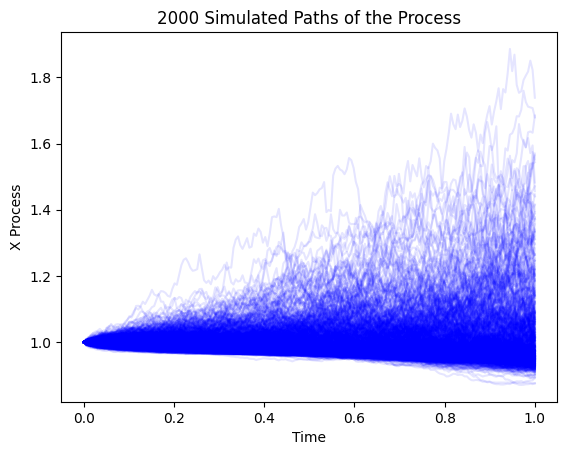

In [10]:
#Generating 1000 paths
l = generate_tensors_I2N(4)
l4=lx4(l)
num_paths=1000
for _ in range(num_paths):
    W = brownian_motion(n, T)
    W_ll = lead_lag_transform(W,T)

    # Initialize signature
    sig_total = np.zeros(dim_sig)
    sig_total[0] = 1.0

    X = np.zeros(n)
    X[0] = x  # Initial condition

    for k in range(1, n):
        segment = W_ll[2*(k-1):2*k+1, :]
        sig_segment = compute_signature(segment, N)
        sig_total = iisignature.sigcombine(sig_total, sig_segment, 4, N)
        sig_total_tensor = signature_to_tensor_list(sig_total, 4, N)
        X[k] = X[0] + inner_prod(l4,sig_total_tensor[1:])  

    plt.plot(np.linspace(0, T, n), X, alpha=0.1, color='blue')

# Final plot settings
plt.xlabel("Time")
plt.ylabel("X Process")
plt.title(f"2000 Simulated Paths of the Process")
plt.show()